In [37]:
from torch.utils.data import Dataset
import torch
import glob
import torchaudio
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

class DatasetGenerator(Dataset):
    """AudioSet Dataset."""

    def __init__(self, data_path, target_sample_rate,  transform):
        """
        Args:
            root_dir (string): Directory with all the sounds.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = data_path
        self.transform = transform
        self.files = glob.glob(self.root_dir + '/**/--0Oh0JxzjQ_30.wav', recursive=True)
        self.transformation = transform
        self.target_sample_rate = target_sample_rate

    def __len__(self):
        #TODO: define how to count the len of the dataset
        return len(self.files)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index, audio_sample_path)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = self._mix_down(signal)
        signal = self._resample(signal, sr)
        signal = self._padding(signal)
        print(f"Signal shape: {signal.shape}")
        signal = self.transformation(signal)
        #fbank = torchaudio.compliance.kaldi.fbank(signal, htk_compat=True, sample_frequency=16000, use_energy=False, window_type='hanning', num_mel_bins=128, dither=0.0, frame_shift=10)
        signal = self._powerToDB(signal)
        signal = torch.squeeze(signal)
        if self.pre_train:
            return signal
        else:
            return signal, label

    def _resample(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _powerToDB(self, signal):
        powerToDB = torchaudio.transforms.AmplitudeToDB(stype='power')
        signal = powerToDB(signal)
        return signal

    def _get_audio_sample_path(self, index):
        return self.files[index]

    def _get_audio_sample_label(self, index, audio_path):
        label = audio_path.split("/")[-2]
        return label

    def _padding(self, signal):
        signal = torch.cat((torch.zeros(1,3700), signal), 1)
        return signal


def plotMelSpectrogram(signal,sr):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(signal,
                             x_axis="time",
                             y_axis="mel",
                             sr=sr)
    plt.colorbar(format="%+2.f")
    plt.show()

In [38]:
AUDIO_DIR = "/home/yhbedoya/Drive/Data Science and Engineering - PoliTo2/Thesis/Audioset"
SAMPLE_RATE = 16000
hanningWindowSeconds = 25/1000
win_length = int(SAMPLE_RATE * hanningWindowSeconds)
print(f'win_length: {win_length}')
n_fft = int(win_length*1.5) #int(SAMPLE_RATE * hanningWindowSeconds)
print(f'n_fft: {n_fft}')
shiftsWindSeconds = 10/1000
hop_len = int(SAMPLE_RATE * shiftsWindSeconds)
print(f'hop_len: {hop_len}')

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate= SAMPLE_RATE,
    n_fft = n_fft,
    win_length = win_length,
    hop_length = hop_len,
    #pad=1850,
    n_mels=128
)

usd = DatasetGenerator(AUDIO_DIR, SAMPLE_RATE, mel_spectrogram)

win_length: 400
n_fft: 600
hop_len: 160


Signal shape: torch.Size([1, 163700])


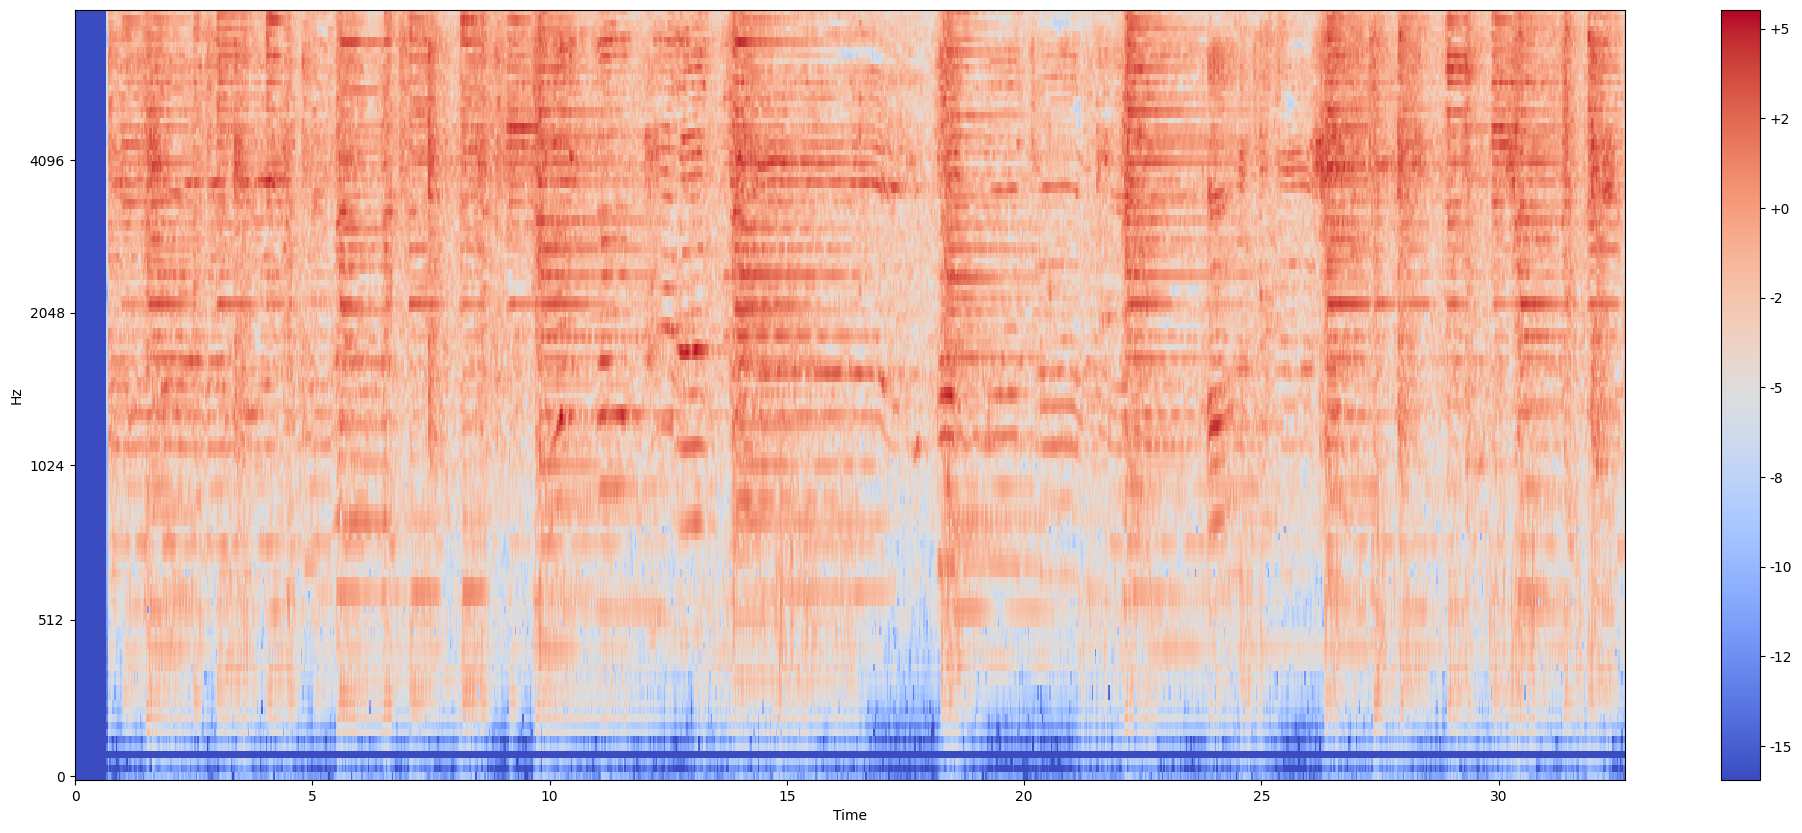

torch.Size([1021, 128])


In [40]:
signal, label = usd[0]
plotMelSpectrogram(np.squeeze(signal.detach().numpy()), SAMPLE_RATE)
print(signal.shape)

In [27]:
print(signal)

tensor([[[-100.0000, -100.0000, -100.0000,  ...,  -41.0260,  -40.2982,
           -36.8254],
         [-100.0000, -100.0000, -100.0000,  ...,  -30.8100,  -30.0822,
           -26.6095],
         [-100.0000, -100.0000, -100.0000,  ...,  -30.4845,  -26.1851,
           -21.1482],
         ...,
         [-100.0000, -100.0000, -100.0000,  ...,  -17.8131,  -14.8233,
           -15.8209],
         [-100.0000, -100.0000, -100.0000,  ...,  -14.3541,  -16.3911,
           -15.7690],
         [-100.0000, -100.0000, -100.0000,  ...,  -27.1174,  -24.2806,
           -21.0501]]])
